In [ ]:
import pandas as pd
from textblob import TextBlob

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

### Load datasets

In [2]:

main_df = pd.read_pickle("./dataset_no_extra.pkl")
new_df = pd.read_pickle("./new_data.pkl")


# main_df = pd.read_pickle("./dataset_without_extra.pkl")

In [6]:
# Remove informative data from new dataset
new_df=new_df[new_df["Informativeness"]==0]

In [7]:
main_df.head()

,Information Source,Information Type,Informativeness,orig_id,annotated_id,text,event,user_id,created_at,retweet_count,...,user_tweet_count,user_friend_count,user_description,default_profile_image,is_verified_user,user_location,user_join_date,user_url,reply_to_user,reply_to_tweet
0,Not labeled,Not labeled,Not related,211040709124440064,211040709124440064,#Intern #US #TATTOO #Wisconsin #Ohio #NC #PA #...,2012_Colorado_wildfires,601864285,2012-06-08T10:23:20.000Z,0,...,402,19,Traveling http://goo.gl/97yT2,True,False,None,Thu Jun 07 13:14:27 +0000 2012,None,NaN,NaN
1,Not labeled,Not labeled,Not related,210864180218167296,211111710294163457,Get in on the fun every Thursday with the @csi...,2012_Colorado_wildfires,245545247,2012-06-07T22:41:52.000Z,2,...,3327,35,Director of Marketing & Promotions for the Col...,False,False,"Coloado Springs, CO",Mon Jan 31 23:05:46 +0000 2011,http://www.csindy.com/colorado/Home,NaN,NaN
2,Not labeled,Not labeled,Not related,211157222699433985,211157222699433985,Welcome to our newest STUDENTathlete- Reagan B...,2012_Colorado_wildfires,487854217,2012-06-08T18:06:19.000Z,0,...,268,2,,True,False,,Thu Feb 09 20:26:05 +0000 2012,None,NaN,NaN
3,Not labeled,Not labeled,Not related,211162553659830272,211162553659830272,Denver Post: #Colorado governor signs bill cre...,2012_Colorado_wildfires,17602802,2012-06-08T18:27:30.000Z,0,...,4392,188,The Reporters Committee for Freedom of the Pre...,False,False,"Arlington, VA",Mon Nov 24 22:14:23 +0000 2008,http://www.rcfp.org,NaN,NaN
4,Not labeled,Not labeled,Not related,211216962162933761,211216962162933761,Pretty sure I'm going to live in Manitou Sprin...,2012_Colorado_wildfires,348495572,2012-06-08T22:03:42.000Z,0,...,3687,203,"free-spirited, ever thinking, world citizen",False,False,"Chillwater, OK",Thu Aug 04 14:41:31 +0000 2011,None,NaN,NaN


In [8]:
main_df.columns

Index(['Information Source', 'Information Type', 'Informativeness', 'orig_id',
       'annotated_id', 'text', 'event', 'user_id', 'created_at',
       'retweet_count', 'favorite_count', 'user_mentions', 'hashtags', 'urls',
       'user_handle', 'user_name', 'user_follower_count',
       'user_favorite_count', 'user_tweet_count', 'user_friend_count',
       'user_description', 'default_profile_image', 'is_verified_user',
       'user_location', 'user_join_date', 'user_url', 'reply_to_user',
       'reply_to_tweet'],
      dtype='object')

In [9]:
main_df["Informativeness"].value_counts()

Related and informative          15314
Related - but not informative     6857
Not related                       2619
Not applicable                     457
Name: Informativeness, dtype: int64

### Remove all features except the text, and make labels only relevant/not relevant

In [10]:
main_df.drop(main_df.columns.difference(['Informativeness','text']), 1, inplace=True)
main_df['Informativeness']=main_df['Informativeness'].map(lambda x: 1 if(x=='Related and informative' ) else 0)
# main_df['Informativeness']=main_df['Informativeness'].map(lambda x: 1 if(x=='Related and informative' or x=='Related - but not informative') else 0)

In [11]:
main_df= pd.concat([main_df, new_df])

In [12]:
main_df['Informativeness'].value_counts()

1    15314
0    14488
Name: Informativeness, dtype: int64

In [13]:
main_df.drop_duplicates(inplace=True)

In [14]:
main_df['Informativeness'].value_counts()

1    15193
0    14450
Name: Informativeness, dtype: int64

In [15]:
len(main_df)

29643

### Keep only english tweets

In [16]:
def is_english(text):

    try:
          language = detect(text)
    except:
          #These will be removed
          print("This row throws and error:", text)
          return False;
    if(language=='en'):
      return True;
    else:
      return False;

In [17]:
main_df=main_df[main_df.apply(lambda x: is_english(x['text']), axis=1)]

In [18]:
len(main_df)

22419

### Process the text

In [19]:
len(main_df[main_df["Informativeness"]==1])

11620

In [20]:
len(main_df[main_df["Informativeness"]==0])

10799

In [21]:

def text_processing(tweet):
    
    #Removing hyperlinks from the tweet
    tweet_no_links=re.sub(r'http\S+', '', tweet)
    
    #Generating the list of words in the tweet (hashtags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = form_sentence(tweet_no_links)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
        return clean_mess
    no_punc_tweet = no_user_alpha(new_tweet)
    
    #Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return " ".join(normalized_tweet)
    
    
    return normalization(no_punc_tweet)

In [22]:
main_df['text']=main_df['text'].apply(text_processing)

In [23]:
main_df.iloc[-3].text

'EPN Tragedies Brought Army Citizens Closer mexicoearthquake news Mexico'

## Baseline model

Split data into X and Y, as well as train/test sets

In [24]:
from sklearn.model_selection import train_test_split



sentences = main_df['text'].values
y = main_df['Informativeness'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.25, random_state=1000)


Vectorize sentances using CountVectorizer

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

# Vevotize each sentance
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

# Too look at the vocabulary encoding
# vectorizer.vocabulary_

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

Evaluate using Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(max_iter=10000)
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.8788581623550401


In [27]:
y_pred = classifier.predict(X_test)
y_pred_prob=classifier.predict_proba(X_test)[:,1]

precision_LR = precision_score(y_test, y_pred)
recall_LR = recall_score(y_test, y_pred)
f1_LR= f1_score(y_test, y_pred)
roc_LR = roc_auc_score(y_test, y_pred_prob)

fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_test, y_pred_prob)

print("Precision: {} \nRecall:{} \nF1 Score: {} \nAUC: {}".format(precision_LR, recall_LR, f1_LR, roc_LR))

Precision: 0.8752989408951144 
Recall:0.8908205841446454 
F1 Score: 0.8829915560916766 
AUC: 0.9494897436537759


In [28]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test,y_pred))

# Using embeddings (Glove)

In [29]:
# This time don't vectorize, but tokenize. Same idea but runs better with Keras and tokenizer assings
# index 1 to most frequent word and so on. While vecotrizer makes each sentcance to a vector of the same
# size (the vocabulary size) and assigns count of how many time a word appears

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[1])
print(X_train[1])



Four million people think affect Typhoon Haiyan Philippines
[282, 586, 8, 189, 39, 13, 76, 10]


In [30]:
# Pad with trailing 0 every tokenized sentance so that they have the same length (the length of the longest sentance)

from keras.preprocessing.sequence import pad_sequences

maxlen = len(max(X_train, key=len)) #length of the longest sentance

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[  42  165  123   35 3583 2291   54    0    0    0    0    0    0    0
    0    0    0    0    0]


In [31]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

Load pretrained data

In [34]:
# Download here: https://nlp.stanford.edu/projects/glove/

embedding_dim = 300
embedding_matrix = create_embedding_matrix(
    'glove_data/glove.6B.300d.txt',
    tokenizer.word_index, embedding_dim)



Percantage of vocabulary covered in the pretrained model

In [35]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.6640093330740813

In [36]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))

model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 19, 300)           6171600   
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                3010      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 6,174,621
Trainable params: 3,021
Non-trainable params: 6,171,600
_________________________________________________________________


In [37]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {}".format(accuracy))
# plot_history(history)

Epoch 1/30
1682/1682 [==============================] - 3s 2ms/step - loss: 0.5198 - accuracy: 0.7450 - val_loss: 0.4419 - val_accuracy: 0.7964
Epoch 2/30
1682/1682 [==============================] - 3s 2ms/step - loss: 0.4422 - accuracy: 0.7959 - val_loss: 0.4362 - val_accuracy: 0.7989
Epoch 3/30
1682/1682 [==============================] - 3s 2ms/step - loss: 0.4257 - accuracy: 0.8049 - val_loss: 0.4601 - val_accuracy: 0.7806
Epoch 4/30
1682/1682 [==============================] - 3s 2ms/step - loss: 0.4206 - accuracy: 0.8069 - val_loss: 0.4162 - val_accuracy: 0.8012
Epoch 5/30
1682/1682 [==============================] - 3s 2ms/step - loss: 0.4177 - accuracy: 0.8098 - val_loss: 0.4071 - val_accuracy: 0.8107
Epoch 6/30
1682/1682 [==============================] - 3s 2ms/step - loss: 0.4131 - accuracy: 0.8106 - val_loss: 0.4162 - val_accuracy: 0.8130
Epoch 7/30
1682/1682 [==============================] - 3s 2ms/step - loss: 0.4108 - accuracy: 0.8124 - val_loss: 0.4074 - val_accuracy:

In [38]:
y_pred =(model.predict(X_test) > 0.5).astype("int32")
y_pred_prob = model.predict(X_test)

precision_Glove_Untrainable = precision_score(y_test, y_pred)
recall_Glove_Untrainable = recall_score(y_test, y_pred)
f1_Glove_Untrainable= f1_score(y_test, y_pred)
roc_Glove_Untrainable = roc_auc_score(y_test, y_pred_prob)

fpr_Glove_Untrainable, tpr_Glove_Untrainable, thresholds_Glove_Untrainable = roc_curve(y_test, y_pred_prob)

print("Precision: {} \nRecall:{} \nF1 Score: {} \nAUC: {}".format(precision_Glove_Untrainable, recall_Glove_Untrainable, f1_Glove_Untrainable, roc_Glove_Untrainable))


Precision: 0.8771498771498771 
Recall:0.7447844228094576 
F1 Score: 0.8055660022564873 
AUC: 0.9090468827322667


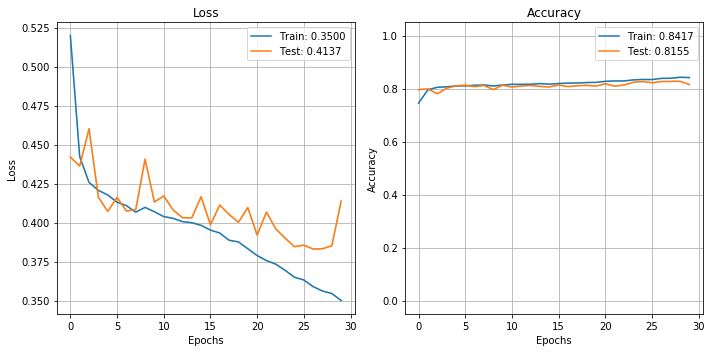

In [39]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt


plot_history(history.history)
plt.show()
plt.close()

### Do the same thing with glove, but this time all parameters are trainable (takes much longer to run)

In [40]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))

model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 19, 300)           6171600   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                3010      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 6,174,621
Trainable params: 6,174,621
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
1682/1682 [==============================] - 121s 72ms/step - loss: 0.3968 - accuracy: 0.8140 - val_loss: 0.3407 - val_accuracy: 0.8464
Epoch 2/20
1682/1682 [==============================] - 117s 70ms/step - loss: 0.2341 - accuracy: 0.9034 - val_loss: 0.2895 - val_accuracy: 0.8748
Epoch 3/20
1682/1682 [==============================] - 110s 65ms/step - loss: 0.1537 - accuracy: 0.9400 - val_loss: 0.3353 - val_accuracy: 0.8651
Epoch 4/20
1682/1682 [==============================] - 113s 67ms/step - loss: 0.0948 - accuracy: 0.9663 - val_loss: 0.3718 - val_accuracy: 0.8690
Epoch 5/20
1682/1682 [==============================] - 112s 67ms/step - loss: 0.0552 - accuracy: 0.9823 - val_loss: 0.4227 - val_accuracy: 0.8660
Epoch 6/20
1682/1682 [==============================] - 113s 67ms/step - loss: 0.0329 - accuracy: 0.9902 - val_loss: 0.4903 - val_accuracy: 0.8619
Epoch 7/20
1682/1682 [==============================] - 115s 68ms/step - loss: 0.0230 - accuracy: 0.9928 - val_loss: 0

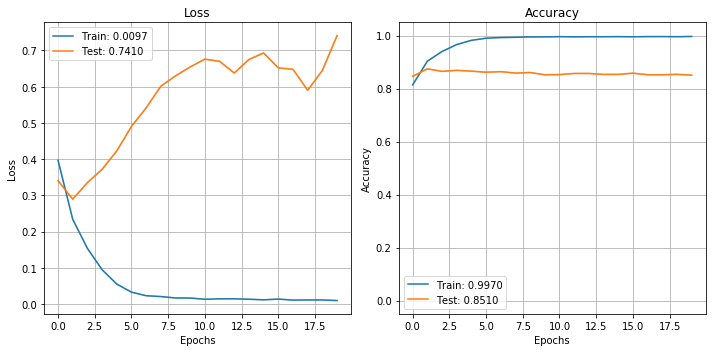

In [41]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {}".format(accuracy))
plot_history(history.history)

In [42]:
y_pred =(model.predict(X_test) > 0.5).astype("int32")
y_pred_prob = model.predict(X_test)

precision_Glove = precision_score(y_test, y_pred)
recall_Glove = recall_score(y_test, y_pred)
f1_Glove = f1_score(y_test, y_pred)
roc_Glove = roc_auc_score(y_test, y_pred_prob)

fpr_Glove, tpr_Glove, thresholds_Glove= roc_curve(y_test, y_pred_prob)

print("Precision: {} \nRecall:{} \nF1 Score: {} \nAUC: {}".format(precision_Glove, recall_Glove, f1_Glove, roc_Glove))


Precision: 0.8312236286919831 
Recall:0.8904728789986092 
F1 Score: 0.8598287728722511 
AUC: 0.9350044288130731


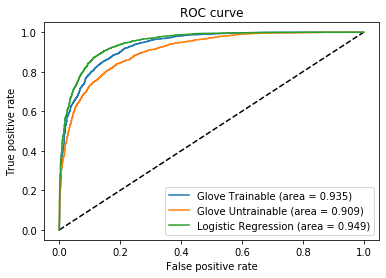

In [43]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_Glove, tpr_Glove, label='Glove Trainable (area = {:.3f})'.format(roc_Glove))
plt.plot(fpr_Glove_Untrainable, tpr_Glove_Untrainable, label='Glove Untrainable (area = {:.3f})'.format(roc_Glove_Untrainable))
plt.plot(fpr_LR, tpr_LR, label='Logistic Regression (area = {:.3f})'.format(roc_LR))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# # plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()